<a href="https://colab.research.google.com/github/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up ( 🍔👀 Food Vision mini)

We've seen the power of the transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
# Check to see if we're using a GPU
!nvidia-smi

Tue Jun  3 13:09:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks. Let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-06-03 13:09:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-03 13:09:49 (117 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, unzip_data, plot_loss_curves, compare_historys, walk_through_dir

## 101 Food Classes: working with less data
our goal is to beat the original Food101 paper with 10% of the training data.

We are using data from Food101 dataset and preprocesed data using [image_data_modification](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/image_data_modification.ipynb) code.

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-06-03 13:09:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  21.4MB/s    in 73s     

2025-06-03 13:11:10 (21.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/omelette'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spring_rolls'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/eggs_benedict'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories and 75 images in '101_food_clas

In [6]:
# Setup data inputs (or make a image into a tensor or numbers)
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validat on 15% of the test data, to save epoch time)

In [7]:
# Create a ModelCheckpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers, Sequential

# Setup data augmentation
data_augmentation = Sequential([
    layers.Resizing(224, 224),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    #layers.Rescaling(1./255)
], name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs, training=True) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay  frozen
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# Get a summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, None, None,     │     4,049,571 │
│                                 │ 1280)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_layer    │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate only 15% of test data
                                           callbacks=[checkpoint_callback])


Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 55s 170ms/step - accuracy: 0.1567 - loss: 3.9537 - val_accuracy: 0.4611 - val_loss: 2.4949
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.4692 - loss: 2.3464 - val_accuracy: 0.5066 - val_loss: 2.0503
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 37s 154ms/step - accuracy: 0.5417 - loss: 1.9201 - val_accuracy: 0.5376 - val_loss: 1.8599
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.5923 - loss: 1.6822 - val_accuracy: 0.5418 - val_loss: 1.7939
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.6226 - loss: 1.5316 - val_accuracy: 0.5553 - val_loss: 1.7420


In [12]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5683 - loss: 1.6640


[1.588280439376831, 0.5853861570358276]

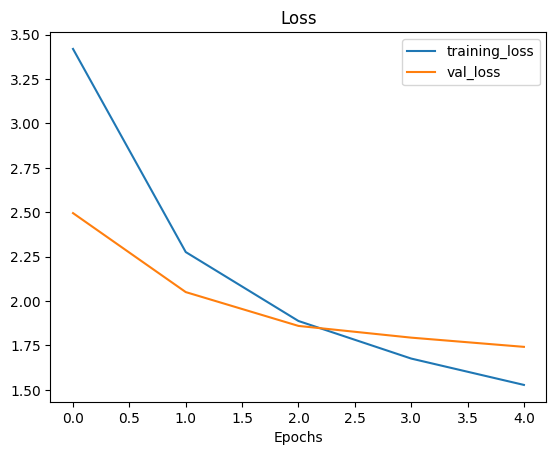

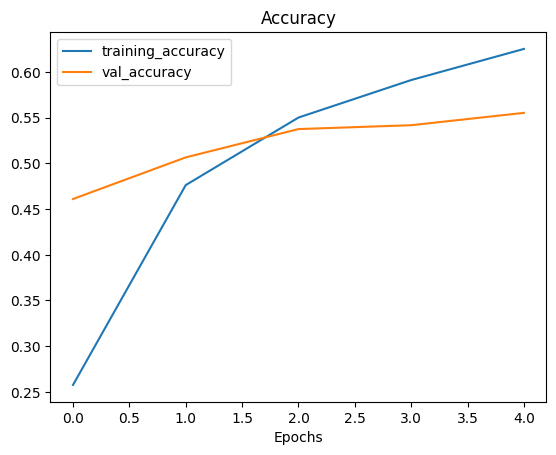

In [13]:
plot_loss_curves(history_all_classes_10_percent)

> ✍ **Observation:** Ideally, the two curves should be very similar to each other. If not, it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data). So it seems, our model may be overfitting a little bit. We will try to reduce the overfitting in further experiment of this notebook.

## Fine-tuning

In [14]:
# Unfreeze last 5 layers in the base model
base_model.trainable = False

for layer in base_model.layers[-5:]:
  layer.trainable = True

In [15]:
# Recompile model with lower learning rate: it's typically best practice to lower the learning rate when fine-tuning
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 False
global_average_pooling_layer True
output_layer True


In [17]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [18]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10  # it is the total epochs = feature extraction epochs 5 + 5 fine tune epochs

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])


Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 51s 161ms/step - accuracy: 0.6295 - loss: 1.5246 - val_accuracy: 0.5622 - val_loss: 1.6895
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 146ms/step - accuracy: 0.6676 - loss: 1.3350 - val_accuracy: 0.5747 - val_loss: 1.6464
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.7038 - loss: 1.2466 - val_accuracy: 0.5805 - val_loss: 1.6147
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - accuracy: 0.7065 - loss: 1.1894 - val_accuracy: 0.5805 - val_loss: 1.6060
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 35s 147ms/step - accuracy: 0.7150 - loss: 1.1409 - val_accuracy: 0.5824 - val_loss: 1.5934
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.7472 - loss: 1.0420 - val_accuracy: 0.5808 - val_loss: 1.5884


In [19]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - accuracy: 0.5967 - loss: 1.5132


[1.4254095554351807, 0.6170297265052795]

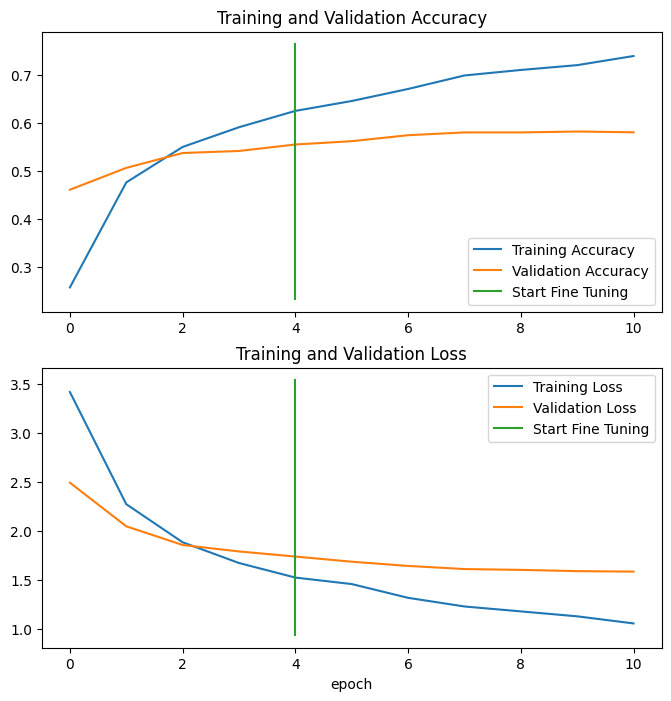

In [20]:
# Compare the histories of feature extraction model with fine-tunining model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use it in an external application, we'll need to save it and export it somewhere.

In [21]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/Colab_Notebooks/101_food_classes_10_percent_saved_big_dog_model.keras")

In [22]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/101_food_classes_10_percent_saved_big_dog_model.keras")

In [23]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 74ms/step - accuracy: 0.5967 - loss: 1.5132


[1.4254095554351807, 0.6170297265052795]

In [24]:
# The results from our loaded model (above) should be very similar to the results below
all_classes_10_percent_fine_tune_results

[1.4254095554351807, 0.6170297265052795]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [25]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2025-06-03 13:23:49--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  11.8MB/s    in 4.4s    

2025-06-03 13:23:54 (10.1 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [26]:
saved_model_path = "/content/06_101_food_class_10_percent_saved_big_dog_model.zip"
unzip_data(saved_model_path)

In [27]:
# Load in saved model
# model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [28]:
# Load as inference-only model using TFSMLayer
layer = tf.keras.layers.TFSMLayer("/content/06_101_food_class_10_percent_saved_big_dog_model", call_endpoint="serving_default")
model = Sequential([layer])

# Save it in `.keras` format (usable in Keras 3+)
model.save("/content/converted_big_dog_model.keras")

# Load the model
model = tf.keras.models.load_model("/content/converted_big_dog_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


**The bellow code is not executable because the model we inport is not saved in the correct format**

In [29]:
# Check to see if loaded model is a trained model

# results_downloaded_model = model.evaluate(test_data)
# results_downloaded_model

In [30]:
# TFSMLayer is inference-only and does not support .evaluate()
# Instead, run predictions and compute metrics manually

# import numpy as np
# from sklearn.metrics import accuracy_score

# # Get true labels
# y_true = np.concatenate([y for x, y in test_data], axis=0)
# y_true_labels = np.argmax(y_true, axis=1)

# # Get predictions
# y_pred_probs = model.predict(test_data)

# # Handle prediction shape
# if len(y_pred_probs.shape) == 1:
#     y_pred = y_pred_probs.astype(int)
# elif len(y_pred_probs.shape) == 2:
#     y_pred = np.argmax(y_pred_probs, axis=1)
# else:
#     raise ValueError("Unexpected prediction shape:", y_pred_probs.shape)

# # Calculate accuracy
# accuracy = accuracy_score(y_true_labels, y_pred)
# print("Accuracy:", accuracy)

In [31]:
# TFSMLayer is inference-only and does not support .evaluate()
# Instead, run predictions and compute metrics manually


import tensorflow as tf
from keras.layers import TFSMLayer
from keras import Sequential
import zipfile
import numpy as np
from sklearn.metrics import accuracy_score

# Predict on the test data
# Assumes test_data is already defined and preprocessed
y_pred_dict = model.predict(test_data)  # Returns a dict

# Extract the actual predictions
# Print keys to confirm the correct one
print("Prediction keys:", y_pred_dict.keys())

# Most likely it's 'predictions'
y_pred_probs = y_pred_dict['predictions'] if 'predictions' in y_pred_dict else list(y_pred_dict.values())[0]

# Get true labels
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_true_labels = np.argmax(y_true, axis=1)

# Convert prediction probabilities to class labels
if len(y_pred_probs.shape) == 1:
    y_pred = y_pred_probs.astype(int)
else:
    y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, y_pred)
print("✅ Accuracy:", accuracy)


790/790 ━━━━━━━━━━━━━━━━━━━━ 59s 66ms/step
Prediction keys: dict_keys(['dense_8'])
✅ Accuracy: 0.6077623762376237


## Making predictions with our trained model

In [32]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1)  # set verbosity to see how long is left

790/790 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step


In [33]:
len(test_data)

790

In [34]:
# How many predictions are there?
len(preds_probs)

1

In [35]:
# What's the shape of our predictions?
# preds_probs.shape

# This code due to our loaded model is not in .keras form
print("Prediction keys:", preds_probs.keys())

y_pred_probs = preds_probs["predictions"] if "predictions" in preds_probs else list(preds_probs.values())[0]

print("Prediction shape: ", y_pred_probs.shape)

Prediction keys: dict_keys(['dense_8'])
Prediction shape:  (25250, 101)


In [36]:
# Let's see what the first 10 predictions look like
y_pred_probs[:10]

array([[5.95420152e-02, 3.57423096e-06, 4.13771793e-02, ...,
        1.41387024e-09, 8.35313622e-05, 3.08976066e-03],
       [9.64016795e-01, 1.37533784e-09, 8.47806572e-04, ...,
        5.42869457e-05, 7.83622039e-12, 9.84656467e-10],
       [9.59258795e-01, 3.25339606e-05, 1.48669921e-03, ...,
        7.18921058e-07, 5.43980946e-07, 4.02762744e-05],
       ...,
       [4.73132759e-01, 1.29311758e-07, 1.48055761e-03, ...,
        5.97503735e-04, 6.69692454e-05, 2.34694835e-05],
       [4.45718952e-02, 4.72655444e-07, 1.22585006e-01, ...,
        6.34987691e-06, 7.53185350e-06, 3.67790204e-03],
       [7.24388838e-01, 1.92496774e-09, 5.23109375e-05, ...,
        1.22914359e-03, 1.57927571e-09, 9.63954590e-05]], dtype=float32)

In [37]:
# What does the first prediction probability array look like?
y_pred_probs[0], len(y_pred_probs[0]), sum(y_pred_probs[0])

(array([5.95420152e-02, 3.57423096e-06, 4.13771793e-02, 1.06606124e-09,
        8.16145640e-09, 8.66401173e-09, 8.09276344e-07, 8.56528800e-07,
        1.98591406e-05, 8.09775031e-07, 3.17279136e-09, 9.86746500e-07,
        2.85322749e-04, 7.80493170e-10, 7.42305245e-04, 3.89165143e-05,
        6.47408478e-06, 2.49775326e-06, 3.78913028e-05, 2.06783596e-07,
        1.55385205e-05, 8.15077669e-07, 2.62307094e-06, 2.00108701e-07,
        8.38281437e-07, 5.42161206e-06, 3.73910893e-06, 1.31506290e-08,
        2.77616479e-03, 2.80519635e-05, 6.85623891e-10, 2.55748964e-05,
        1.66889862e-04, 7.64078523e-10, 4.04528459e-04, 1.31507303e-08,
        1.79573203e-06, 1.44482249e-06, 2.30628606e-02, 8.24673009e-07,
        8.53664801e-07, 1.71387228e-06, 7.05256798e-06, 1.84022664e-08,
        2.85535293e-07, 7.94838888e-06, 2.06817231e-06, 1.85253583e-07,
        3.36196315e-08, 3.15227371e-04, 1.04109395e-05, 8.54489087e-07,
        8.47418368e-01, 1.05554018e-05, 4.40951169e-07, 3.740402

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each predict method.

In [38]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(y_pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {y_pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {y_pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95420152e-02 3.57423096e-06 4.13771793e-02 1.06606124e-09
 8.16145640e-09 8.66401173e-09 8.09276344e-07 8.56528800e-07
 1.98591406e-05 8.09775031e-07 3.17279136e-09 9.86746500e-07
 2.85322749e-04 7.80493170e-10 7.42305245e-04 3.89165143e-05
 6.47408478e-06 2.49775326e-06 3.78913028e-05 2.06783596e-07
 1.55385205e-05 8.15077669e-07 2.62307094e-06 2.00108701e-07
 8.38281437e-07 5.42161206e-06 3.73910893e-06 1.31506290e-08
 2.77616479e-03 2.80519635e-05 6.85623891e-10 2.55748964e-05
 1.66889862e-04 7.64078523e-10 4.04528459e-04 1.31507303e-08
 1.79573203e-06 1.44482249e-06 2.30628606e-02 8.24673009e-07
 8.53664801e-07 1.71387228e-06 7.05256798e-06 1.84022664e-08
 2.85535293e-07 7.94838888e-06 2.06817231e-06 1.85253583e-07
 3.36196315e-08 3.15227371e-04 1.04109395e-05 8.54489087e-07
 8.47418368e-01 1.05554018e-05 4.40951169e-07 3.74040246e-05
 3.53062496e-05 3.24889952e-05 6.73144605e-

In [39]:
test_data.class_names[52]

'gyoza'

In [40]:
# Get the pred classes of each label
pred_classes = y_pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to the original test dataset labels.

In [41]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [42]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())  # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10

[np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0),
 np.int64(0)]

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [43]:
# results_downloaded_model

In [44]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [45]:
# Does this metric come close to our model's evaluate results
import numpy as np
np.isclose(y_pred_probs[1], sklearn_accuracy)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

## Let's get visual: making a confusion matrix

In [46]:
from helper_functions import make_confusion_matrix

In [47]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [49]:
# We need to make some changes to our make_confusion_matrix_function to ensure the x-labels print vertically
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [50]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), let's try it out.

In [51]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

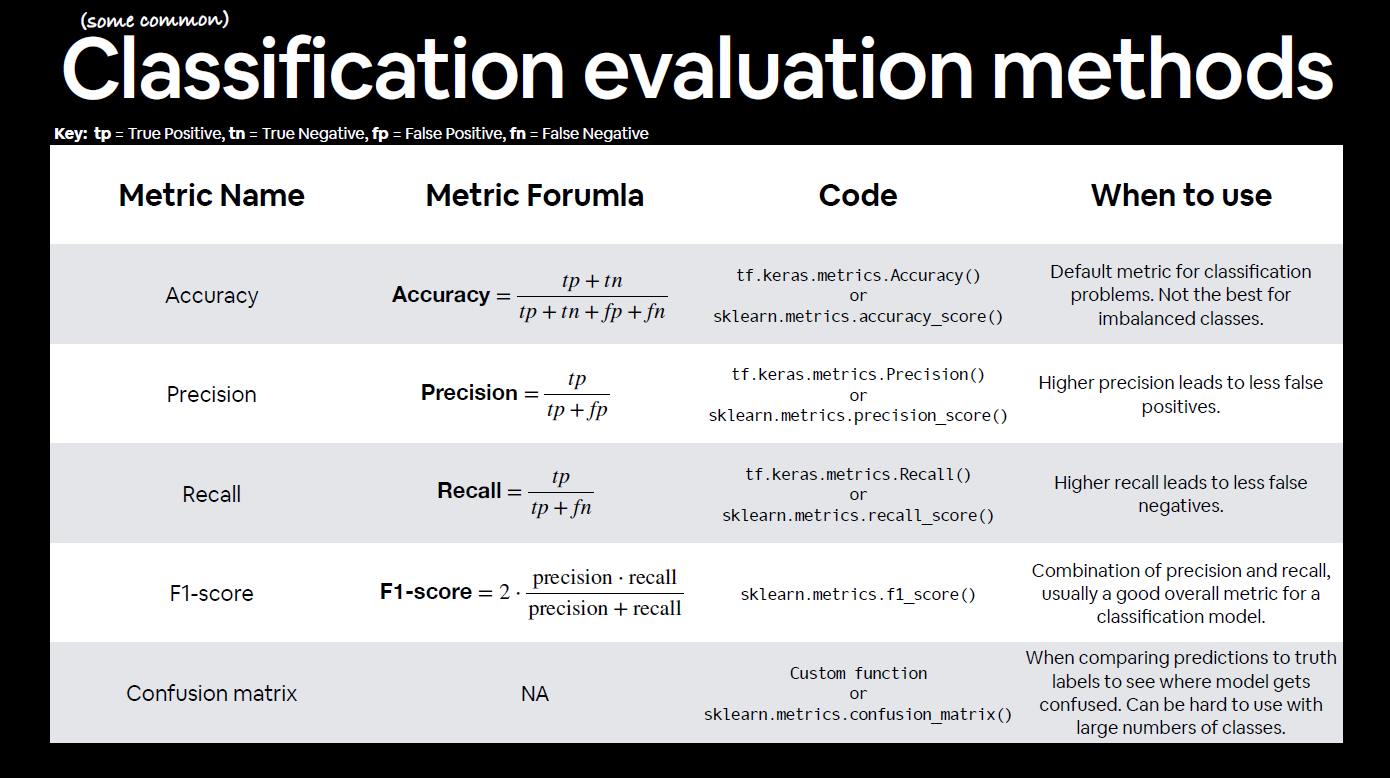

The numbers above give a great class-by-class evaluation of our model's predictions but with so mnay classes, they're quite hard to understand.

Let's create a visualization to get a better understanding.

In [53]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713755,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.5440806045340051,
  'support': 250.0},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.4186046511627907,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'sup

Let's plot all of our classes F1-scores.

In [54]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores


{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713755,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5440806045340051,
 'beet_salad': 0.4186046511627907,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056105,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.3674418604651163,
 'cheese_plate': 0.5654135338345865,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.4526166902404526,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.46255506607929514,
 'creme_brulee'

In [55]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [58]:
f1_scores

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


In [63]:
print(f1_scores[:10])
print("=================================")
print(f1_scores[-10:])

            class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429
         class_names  f1-score
96             tacos  0.380952
15           ceviche  0.367442
99      tuna_tartare  0.353562
82           ravioli  0.342857
93             steak  0.342342
56  huevos_rancheros  0.339833
22  chocolate_mousse  0.329159
77         pork_chop  0.308756
39         foie_gras  0.297491
0          apple_pie  0.240566
